- 将weight单独作为特征输入到模型中

In [41]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
# from sklearn.externals import joblib
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score
import warnings
import torch.nn as nn
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
alldata = data[(data.asin=='B07QHSZGXC')][['data_date','ordered_units']].sort_values('data_date')
alldata.shape

(626, 2)

In [4]:
alldata.head(2)

,data_date,ordered_units
15974,2019-12-02,1034
15937,2019-12-03,193


## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [5]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

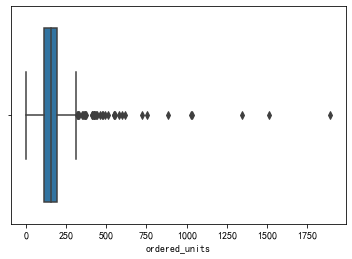

In [6]:
sns.boxplot(alldata.ordered_units)

In [7]:
alldata.drop(alldata[alldata.ordered_units > 1000].index, inplace=True)

In [8]:
alldata.shape

(612, 2)

### 设置样本权重

In [9]:
alldata['weight'] = alldata.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

In [10]:
alldata.head(1)

,data_date,ordered_units,weight
15937,2019-12-03,193,1


### 缺失值

In [11]:
alldata.isnull().sum()

data_date        0
ordered_units    0
weight           0
dtype: int64

无缺失值不用处理

### 创造特征

In [12]:
def create_feature(df):
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday

    df.drop('data_date', axis=1, inplace=True)
    return df

In [13]:
alldata = create_feature(alldata)

In [14]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday
15937,193,1,2019,12,3,1
15902,212,2,2019,12,4,2
15869,211,3,2019,12,5,3


In [15]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

### 编码

In [16]:
x_train.head(2)

,weight,year,month,day,weekday
16633,410,2021,1,15,4
15361,18,2019,12,20,4


In [17]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_train.shape

(550, 603)

In [18]:
x_test = encoder.transform(x_test)

## 评判标准

In [19]:
def metrics1(y_true, y_pred):
    return 1 - (abs(y_true.sum() - y_pred.sum()) / y_true.sum())

def metrics2(y_true, y_pred):
    return 1 - (abs(y_true - y_pred) / y_true).mean()

## 训练

### sklearn api

In [20]:
xgbr = XGBRegressor(n_estimators=1500, 
             learning_rate=0.3, 
             max_depth=5, 
             subsample=0.8, 
             colsample_bytree=1, 
             objective='reg:squarederror',
             base_score=0.5,
             gamma=0,
             n_jobs=8)

In [21]:
xgbr.fit(x_train, y_train,  early_stopping_rounds=20, eval_set=[(x_test, y_test)])

[0]	validation_0-rmse:154.25540
[1]	validation_0-rmse:122.38364
[2]	validation_0-rmse:104.27074
[3]	validation_0-rmse:92.75091
[4]	validation_0-rmse:86.41016
[5]	validation_0-rmse:82.12442
[6]	validation_0-rmse:79.58036
[7]	validation_0-rmse:76.72334
[8]	validation_0-rmse:75.65611
[9]	validation_0-rmse:74.94233
[10]	validation_0-rmse:74.14591
[11]	validation_0-rmse:73.95249
[12]	validation_0-rmse:72.28938
[13]	validation_0-rmse:72.23556
[14]	validation_0-rmse:72.10578
[15]	validation_0-rmse:71.87485
[16]	validation_0-rmse:71.86485
[17]	validation_0-rmse:72.96227
[18]	validation_0-rmse:73.30297
[19]	validation_0-rmse:73.41652
[20]	validation_0-rmse:73.40372
[21]	validation_0-rmse:73.12312
[22]	validation_0-rmse:73.82044
[23]	validation_0-rmse:76.28346
[24]	validation_0-rmse:76.38163
[25]	validation_0-rmse:76.62601
[26]	validation_0-rmse:76.73647
[27]	validation_0-rmse:76.06133
[28]	validation_0-rmse:75.68337
[29]	validation_0-rmse:75.34209
[30]	validation_0-rmse:76.65482
[31]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### xgboost api

In [22]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'eta': 0.3,
          'objective': 'reg:squarederror',
          'gamma': 0,
          'max_depth': 5,
          'subsample': 0.8,
          'colsample_bytree': 1,
          'base_score': 0.5,
          'n_jobs': 8}

model = xgb.train(params, dtrain, 1500, early_stopping_rounds=20, evals=[(dtest, 'test')])

[0]	test-rmse:154.25540
[1]	test-rmse:122.38364
[2]	test-rmse:104.27074
[3]	test-rmse:92.75091
[4]	test-rmse:86.41016
[5]	test-rmse:82.12442
[6]	test-rmse:79.58036
[7]	test-rmse:76.72334
[8]	test-rmse:75.65611
[9]	test-rmse:74.94233
[10]	test-rmse:74.14591
[11]	test-rmse:73.95249
[12]	test-rmse:72.28938
[13]	test-rmse:72.23556
[14]	test-rmse:72.10578
[15]	test-rmse:71.87485
[16]	test-rmse:71.86485
[17]	test-rmse:72.96227
[18]	test-rmse:73.30297
[19]	test-rmse:73.41652
[20]	test-rmse:73.40372
[21]	test-rmse:73.12312
[22]	test-rmse:73.82044
[23]	test-rmse:76.28346
[24]	test-rmse:76.38163
[25]	test-rmse:76.62601
[26]	test-rmse:76.73647
[27]	test-rmse:76.06133
[28]	test-rmse:75.68337
[29]	test-rmse:75.34209
[30]	test-rmse:76.65482
[31]	test-rmse:76.72135
[32]	test-rmse:76.90307
[33]	test-rmse:76.67297
[34]	test-rmse:76.79257
[35]	test-rmse:76.83244
[36]	test-rmse:76.50056


## 测试

### sklearn api

In [23]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred), 
                                                              metrics2(y_test, y_pred), 
                                                              r2_score(y_test, y_pred)))

metrics1: 0.906
metrics2: 0.561
r2: 0.339


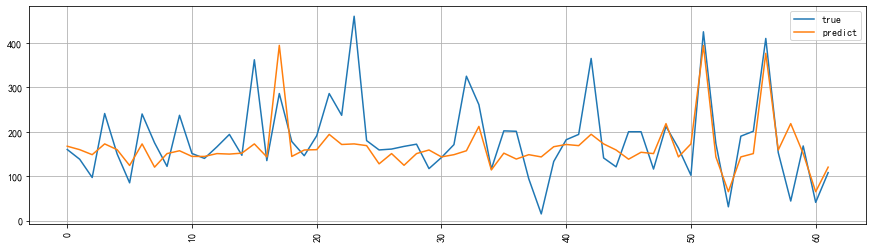

In [24]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

### xgboost api

In [25]:
dtest = xgb.DMatrix(x_test, y_test)

In [26]:
y_pred = model.predict(dtest)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred), 
                                                              metrics2(y_test, y_pred), 
                                                              r2_score(y_test, y_pred)))

metrics1: 0.885
metrics2: 0.592
r2: 0.251


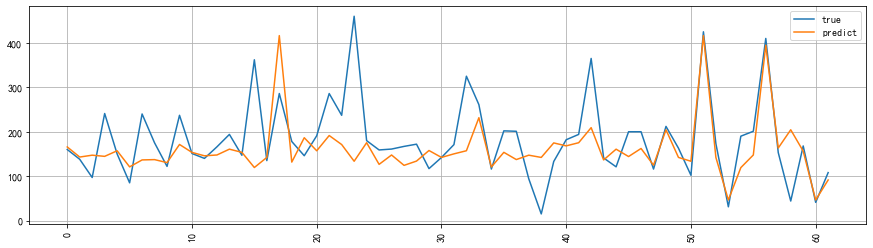

In [27]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [28]:
model.get_score(importance_type='gain')

{'f564': 205001.5718375,
 'f291': 53440.036046,
 'f556': 28645.509545555557,
 'f555': 43755.428700000004,
 'f290': 37954.40097785714,
 'f551': 30762.38363333333,
 'f131': 865.148438,
 'f550': 96491.31013499999,
 'f347': 38496.75,
 'f346': 35294.65625,
 'f352': 5068.75,
 'f6': 6004.1464844,
 'f18': 7894.25,
 'f17': 3465.576710133333,
 'f559': 39735.116700000006,
 'f563': 27665.163940000002,
 'f348': 15343.373046666668,
 'f353': 17125.125,
 'f3': 13721.140995000002,
 'f8': 19865.59896666667,
 'f24': 404.5625,
 'f326': 25539.442526363637,
 'f350': 10892.891599999999,
 'f597': 7099.679225,
 'f19': 5679.0625,
 'f324': 20691.872520833334,
 'f345': 20987.534695000002,
 'f351': 14824.38981,
 'f7': 11111.819013333334,
 'f562': 29509.263033333333,
 'f292': 6250.813965,
 'f293': 5965.810545,
 'f331': 21016.6992975,
 'f587': 8285.086940000001,
 'f595': 7980.688313333332,
 'f553': 14548.663590000002,
 'f560': 27390.0132,
 'f323': 14169.378843333332,
 'f548': 1276.70117,
 'f249': 8758.76563,
 'f557'

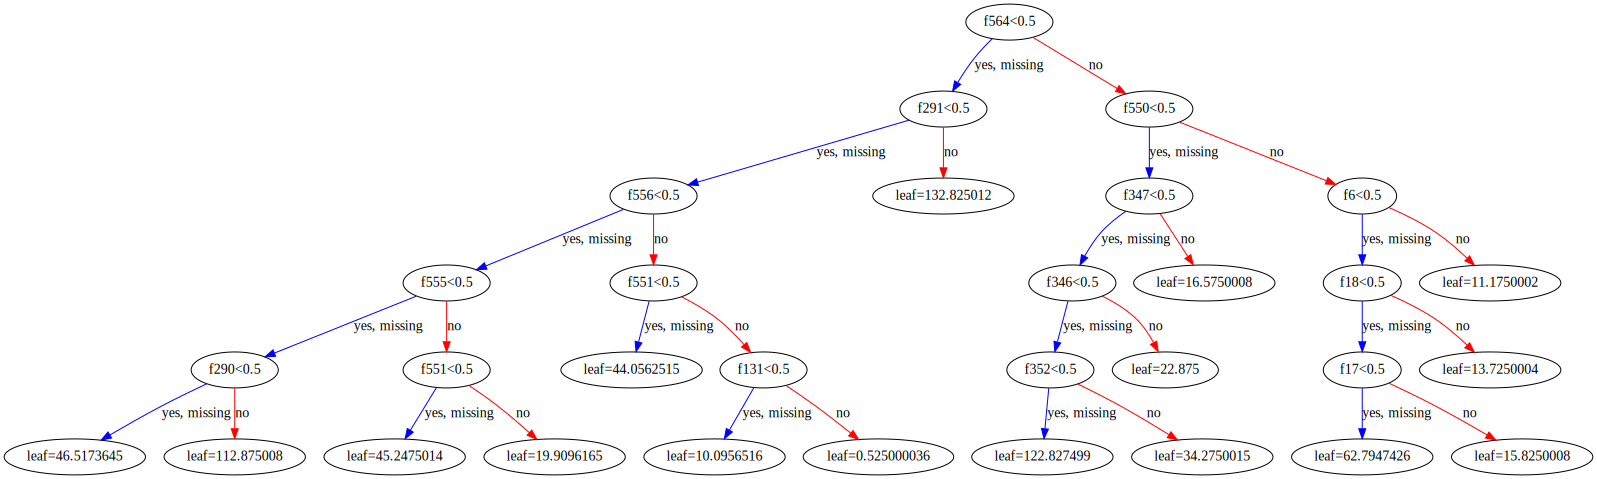

In [29]:
xgb.to_graphviz(model, num_trees=0)

[14:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.00959796, 0.01645038, 0.67658573, 0.29736587], dtype=float32)

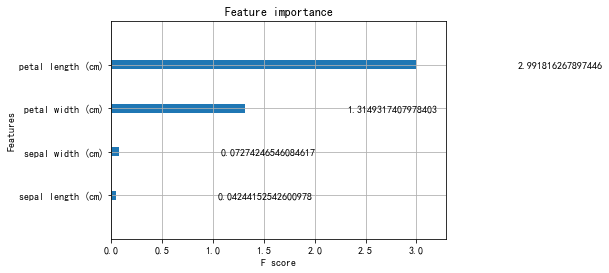

In [30]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [31]:
model.feature_importances_.sum()

1.0

In [32]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

0.6766022886607264

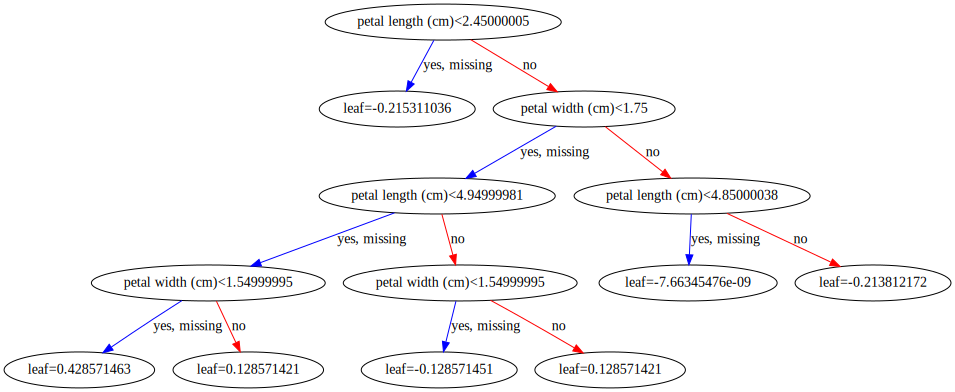

In [33]:
xgb.to_graphviz(model, num_trees=1)

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
dt = DecisionTreeClassifier(max_depth=2)

In [36]:
dt.fit(x, y)

DecisionTreeClassifier(max_depth=2)

In [37]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [38]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

array([0.        , 0.        , 0.56199095, 0.43800905])

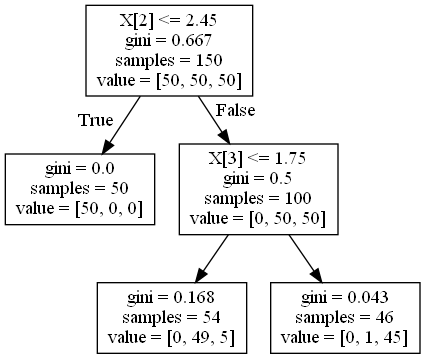

In [39]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())